<a href="https://colab.research.google.com/github/hebertbruno/PGENE-613-Trabalho-05/blob/main/Trabalho05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from google.colab import drive
# Montar o Google Drive
drive.mount('/content/drive')

# Com aumento de dados, o ImageDataGenerator faz todo o trabalho de pré-processamento e loteamento, entregando os dados no formato correto.
# Sem aumento, e necessario replicar manualmente essa funcionalidade usando tf.data.Dataset para garantir que os dados sejam fornecidos ao modelo em lotes e no formato esperado


def create_dataset(x, y, batch_size=64, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(x))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


Mounted at /content/drive


In [4]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

# Carregar a base CIFAR-100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalizar os dados
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Normalizacao adicional
mean = np.mean(x_train, axis=(0, 1, 2, 3))
std = np.std(x_train, axis=(0, 1, 2, 3))
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

# Transformar rotulos em one-hot encoding
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

# Opcao para usar aumento de dados
use_data_augmentation = True

if use_data_augmentation:
    # Divisao estratificada entre as classes
    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train, test_size=0.2, stratify=np.argmax(y_train, axis=1), random_state=42
    )

    # Gerador de dados com aumento para o conjunto de treinamento
    datagen_train = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    # Gerador de dados para validacao (sem aumento)
    datagen_val = ImageDataGenerator()

    # Criar os geradores
    train_gen = datagen_train.flow(x_train, y_train, batch_size=64)
    val_gen = datagen_val.flow(x_val, y_val, batch_size=64)

else:
    # Divisao estratificada sem aumento de dados
    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train, test_size=0.2, stratify=np.argmax(y_train, axis=1), random_state=42
    )

    # Criar datasets manuais para treinamento e validacao
    def create_dataset(x, y, batch_size, shuffle=True):
        dataset = tf.data.Dataset.from_tensor_slices((x, y))
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(x))
        dataset = dataset.batch(batch_size)
        return dataset

    train_gen = create_dataset(x_train, y_train, batch_size=64, shuffle=True)
    val_gen = create_dataset(x_val, y_val, batch_size=64, shuffle=False)

# Conferir os tamanhos dos conjuntos
print("Tamanho do conjunto de treinamento:", x_train.shape, y_train.shape)
print("Tamanho do conjunto de validação:", x_val.shape, y_val.shape)
print("Tamanho do conjunto de teste:", x_test.shape, y_test.shape)

# Exemplo de visualizacao de imagens no modo sem aumento de dados
if not use_data_augmentation:
    for i in range(5):
        plt.imshow(x_train[i])
        plt.title(f"Rótulo: {np.argmax(y_train[i])}")
        plt.show()


Tamanho do conjunto de treinamento: (40000, 32, 32, 3) (40000, 100)
Tamanho do conjunto de validação: (10000, 32, 32, 3) (10000, 100)
Tamanho do conjunto de teste: (10000, 32, 32, 3) (10000, 100)


**SUBSTITUIR CONFIGURACAO NO MODELO**



In [ ]:
'''
1. Configuracao 1 (4 cabecas, 8 blocos de transformer):
image_size = 32
patch_size = 6
num_classes = 100
embed_dim = 32  # Tamanho da representacao interna
num_heads = 4    # Numero de cabecas no MSA
num_transformer_blocks = 8  # Numero de blocos Transformer

SEM AUMENTO DE DADOS:
Epoch 40: early stopping
Acuracia no teste: 36.81%
Perda no teste: 2.6268

COM AUMENTO DE DADOS:
50 épocas

Acuracia no teste: 39.69%
Perda no teste: 2.3435

#############################################################

2. Configuracao 2 (4 cabecas, 12 blocos de transformer):
image_size = 32
patch_size = 6
num_classes = 100
embed_dim = 32  # Tamanho da representacao interna
num_heads = 4    # Numero de cabecas no MSA
num_transformer_blocks = 12  # Numero de blocos Transformer

SEM AUMENTO DE DADOS:
Epoch 36: early stopping

Acuracia no teste: 36.36%
Perda no teste: 2.6703


COM AUMENTO DE DADOS:
50 épocas
Acuracia no teste: 39.69%
Perda no teste: 2.3554

#############################################################

3. Configuracao 3 (6 cabecas, 8 blocos de transformer):
image_size = 32
patch_size = 6
num_classes = 100
embed_dim = 32  # Tamanho da representacao interna ajustavel
num_heads = 6    # Numero de cabecas no MSA
num_transformer_blocks = 8  # Numero de blocos Transformer


SEM AUMENTO DE DADOS:
Epoch 33: early stopping
Acuracia no teste: 35.34%
Perda no teste: 2.7229


COM AUMENTO DE DADOS:
50 EPOCAS
Acuracia no teste: 43.32%
Perda no teste: 2.2001

##############################################################

4. Configuracao 4 (6 cabecas, 12 blocos de transformer):
image_size = 32
patch_size = 6
num_classes = 100
embed_dim = 32  # Tamanho da representacao interna ajustavel
num_heads = 6    # Numero de cabecas no MSA
num_transformer_blocks = 12  # Numero de blocos Transformer

SEM AUMENTO DE DADOS:
Epoch 32: early stopping
Acuracia no teste: 34.98%
Perda no teste: 2.7777

COM AUMENTO DE DADOS:

Acuracia no teste: 39.13%
Perda no teste: 2.3716

################################


'''

DEFINICAO DO MODELO VIT

In [5]:
import tensorflow as tf
from tensorflow.keras import layers

def create_vit_model(image_size, patch_size, num_classes,
                     embed_dim, num_heads, num_transformer_blocks):
    num_patches = (image_size // patch_size) ** 2

    # Camada de divisão em patches
    class PatchEmbed(layers.Layer):
        def __init__(self, patch_size, embed_dim, **kwargs):
            super().__init__(**kwargs)
            self.projection = layers.Conv2D(
                filters=embed_dim, kernel_size=patch_size, strides=patch_size
            )
            self.flatten = layers.Reshape((-1, embed_dim))
            self.norm = layers.LayerNormalization()

        def call(self, x):
            x = self.projection(x)
            x = self.flatten(x)
            return self.norm(x)

    # Camada de codificacao de patches
    class PatchEncoder(layers.Layer):
        def __init__(self, num_patches, embed_dim, **kwargs):
            super().__init__(**kwargs)
            self.pos_embedding = layers.Embedding(input_dim=num_patches+1, output_dim=embed_dim)
            self.cls_token = self.add_weight(shape=(1, 1, embed_dim), name="cls_token")
            self.positions = tf.range(start=0, limit=num_patches + 1, delta=1)

        def call(self, patches):
            batch_size = tf.shape(patches)[0]
            cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, tf.shape(patches)[-1]])
            x = tf.concat([cls_tokens, patches], axis=1)
            x += self.pos_embedding(self.positions)
            return x

    # Construindo o modelo
    inputs = layers.Input(shape=(image_size, image_size, 3))
    patches = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)(inputs)
    encoded_patches = PatchEncoder(num_patches=num_patches, embed_dim=embed_dim)(patches)

    # Blocos Transformer
    for _ in range(num_transformer_blocks):
        x1 = layers.LayerNormalization()(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x1, x1)

        # Adicionando Dropout na atencao
        attention_output = layers.Dropout(0.1)(attention_output)

        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization()(x2)

        # Camada densa com regularização L2
        x3 = layers.Dense(units=embed_dim * 4, activation="gelu", kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x3)

        #x3 = layers.Dense(units=embed_dim * 4, activation="gelu")(x3)

        # Dropout após a camada densa
        x3 = layers.Dropout(0.1)(x3)  # Aplique dropout na saida da camada densa

        x3 = layers.Dense(units=embed_dim)(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Classificação
    x = layers.LayerNormalization()(encoded_patches[:, 0])

    # Adicionando regularizacao L2 na camada final de saida
    #outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    # Camada sem regularizacao
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Configuracoes do modelo
image_size = 32
patch_size = 6
num_classes = 100
embed_dim = 32  # Tamanho da representacao interna ajustavel
num_heads = 6    # Número de cabeças no MSA
num_transformer_blocks = 8  # Num de blocos Transformer

vit_model = create_vit_model(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_transformer_blocks=num_transformer_blocks
)

vit_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_embed_1             │ (None, 25, 32)         │          3,552 │ input_layer_1[0][0]    │
│ (PatchEmbed)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder_1           │ (None, 26, 32)         │            864 │ patch_embed_1[0][0]    │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_19    │ (None, 26, 32)         │             64 │ patch_encoder_1[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_8    │ (None, 26, 32)         │         25,184 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 26, 32)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 26, 32)         │              0 │ dropout_25[0][0],      │
│                           │                        │                │ patch_encoder_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_20    │ (None, 26, 32)         │             64 │ add_16[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 26, 128)        │          4,224 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 26, 128)        │              0 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 26, 32)         │          4,128 │ dropout_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 26, 32)         │              0 │ dense_18[0][0],        │
│                           │                        │                │ add_16[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_21    │ (None, 26, 32)         │             64 │ add_17[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_9    │ (None, 26, 32)         │         25,184 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_28 (Dropout) 

 Total params: 277,092 (1.06 MB)

 Trainable params: 277,092 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

TREINAMENTO

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import os

checkpoint_dir = "/content/drive/My Drive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

# Compilaco do modelo
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Taxa de aprendizado ajustavel
    loss="categorical_crossentropy",  # Funcao de perda para classificacao multiclasse
    metrics=["accuracy"]
)

# Checkpoint para salvar o modelo periodicamente
checkpoint_filepath = os.path.join(checkpoint_dir, "vit_best_checkpoint.weights.h5")
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Parada antecipada
early_stopping = EarlyStopping(
    patience=10,  # paciencia de 10 epocas
    verbose=1
)

# Callback de reducao da taxa de aprendizado
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitora a perda de validacao
    factor=0.7,          # Reduz a taxa de aprendizado pela metade
    patience=5,          # Espera 5 epocas sem melhora
    min_lr=1e-6,         # Define um limite minimo para a taxa de aprendizado
    verbose=1            # Mostra as mensagens de ajuste da taxa
)



# Treinamento do modelo
history = vit_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0384 - loss: 4.4212
Epoch 1: val_accuracy improved from -inf to 0.08120, saving model to /content/drive/My Drive/checkpoints/vit_best_checkpoint.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.0384 - loss: 4.4208 - val_accuracy: 0.0812 - val_loss: 4.0194 - learning_rate: 0.0010
Epoch 2/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0921 - loss: 3.9572
Epoch 2: val_accuracy improved from 0.08120 to 0.12540, saving model to /content/drive/My Drive/checkpoints/vit_best_checkpoint.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - accuracy: 0.0921 - loss: 3.9569 - val_accuracy: 0.1254 - val_loss: 3.7052 - learning_rate: 0.0010
Epoch 3/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.1344 - loss: 3.6917
Epoch 3: val_accuracy improved from 0.12540 to 0.15070, saving model to /content/drive/My Drive/checkpoints/vit_best_checkpoint.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accur

GRAFICOS

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step


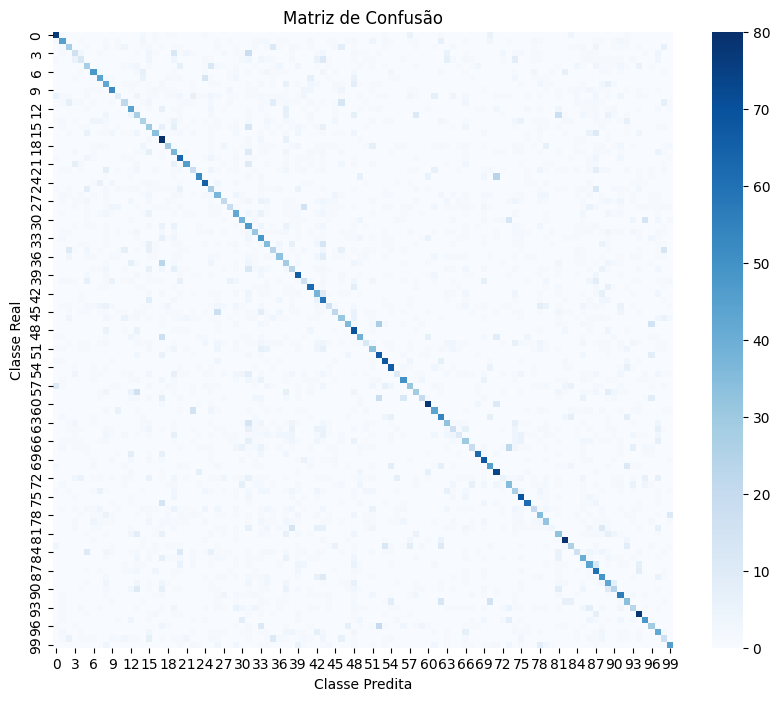

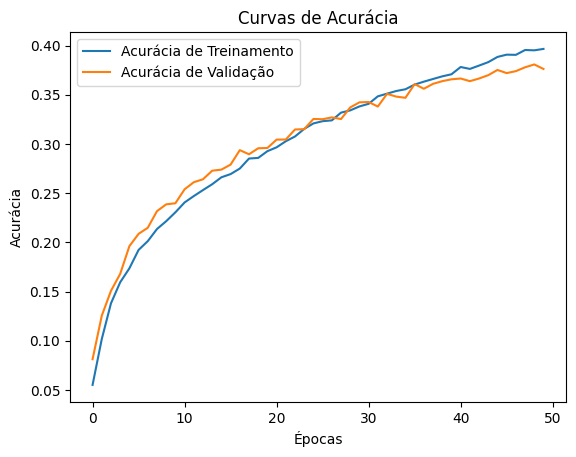

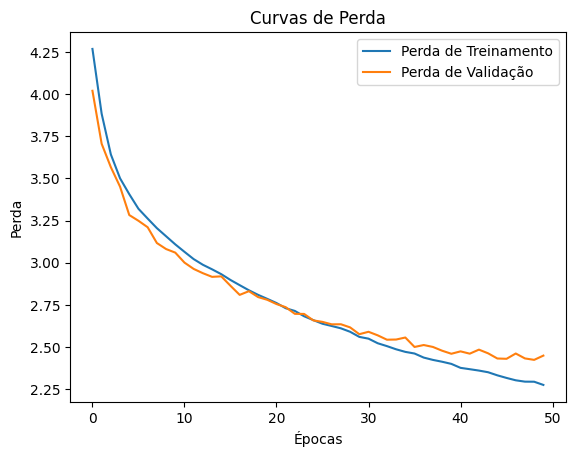

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Predicoes no conjunto de teste
y_pred = vit_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Gerar a matriz de confusao
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotar a matriz de confusao
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

#import matplotlib.pyplot as plt

# Plotando a acurácia
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Curvas de Acurácia')
plt.show()

# Plotando a perda
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Curvas de Perda')
plt.show()




In [8]:
from google.colab import drive
drive.mount('/content/drive')
import os

# Caminho para o checkpoint salvo
checkpoint_filepath = "/content/drive/My Drive/checkpoints/vit_best_checkpoint.weights.h5"

try:
    # Carregar os pesos salvos
    vit_model.load_weights(checkpoint_filepath)
    print("Pesos carregados com sucesso!")
except Exception as e:
    print("Erro ao carregar os pesos:", e)

# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = vit_model.evaluate(x_test, y_test)
print(f"Acuracia no teste: {test_accuracy * 100:.2f}%")
print(f"Perda no teste: {test_loss:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Pesos carregados com sucesso!
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3901 - loss: 2.3987
Acuracia no teste: 39.09%
Perda no teste: 2.3826
